## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import least_squares,minimize
from scipy.integrate import simpson

## Constants

In [2]:
NA = 6.02214076E23  # Avogadro's number
Ntrue = 217 #Number of ions used
k = 0.785  # units: kJ/mol/nm^2 - force constant being used in calculations
R = 8.31446261815324  # units: J/(mol*K) - ideal gas constant
T = 300  # units: K - temperature used for calculations
L_x, L_y, L_z = 4.8, 4.8, 14.4

## Extra info

In [3]:
# # Alirezza SI nm-based answers
# print(1.9247 / (conversion_factor ** (-0.5)))
# print(9.3393E-2 / (conversion_factor ** (-1)))
# print(3.4572E-2 / (conversion_factor **(-2)))

<!-- exp_osm_coeff=0.936,molarity=0.976*(mole/litre)
exp_osm_coeff=0.984,molarity=1.923*(mole/litre)
exp_osm_coeff=1.045,molarity=2.823*(mole/litre) -->

## Plotting initial concentration profiles

In [4]:
def compute_c_profile(xvg_file):
    """
    Computes a concentration profile from an XVG file by averaging symmetric parts of the profile.

    Parameters
    ----------
    xvg_file : str
        The path to the XVG file containing the number density data.
    
    Returns
    -------
    z_coords : numpy.ndarray
        The z-coordinates of the concentration profile.
    c_profile : numpy.ndarray
        The symmetric concentration profile.
    """
    z_coords, rho = np.loadtxt(xvg_file, comments=["@", "#"], unpack=True)
    # rho = rho / NA * 1E27 / 1000  # number density in mol/L

    mid_idx = int(len(rho) / 2 - 1)
    c_profile = 0.5 * (rho[:mid_idx + 1][::-1] + rho[mid_idx:-1])  # in mol/L
    z_coords = z_coords[:mid_idx + 1]  # in nm

    return z_coords, c_profile


In [5]:
z, c_original = compute_c_profile("density_hw_original_288.xvg")
z, c_1 = compute_c_profile("density_hw_r1.xvg")  # replicate 1
z, c_2 = compute_c_profile("density_hw_r2.xvg")  # replicate 2
z, c_3 = compute_c_profile("density_hw_r3.xvg")  # replicate 3

In [6]:
# List concentration profiles
concentration_profiles = np.array([c_original,c_1,c_2,c_3])

### Normalizing Densities

Note from Dr Shirts: It is more rigorous to normalize the densities, since we know what the total number must be. 

Eq 13: $$ L_{x} L_{y} \int^{L_{z}/2}_{-L_{z}/2} C_{s}(z) dz = N_{s}$$

In [7]:
# Estimate the total number of ions, N_s (using Equation 13)

for c in concentration_profiles:
    N_s = L_x * L_y * simpson(c, z)
    print(N_s)  # this should compare to number of ions used (3m used 188)
    c /= (N_s/Ntrue)
    
# # verify normalization worked.
# for c in concentration_profiles:
#     N_s = L_x * L_y * simpson(c, z)
#     print(N_s)  # compare to number of ions used (3m used 188)
    

217.00690232505607
217.003938339552
217.26231075196793
216.96056792831993


/tmp/ipykernel_200423/2072625792.py:4: DeprecationWarning: You are passing x=[0.025 0.075 0.125 0.175 0.225 0.275 0.325 0.375 0.425 0.475 0.525 0.575
 0.625 0.675 0.725 0.775 0.825 0.875 0.925 0.975 1.025 1.075 1.125 1.175
 1.225 1.275 1.325 1.375 1.425 1.475 1.525 1.575 1.625 1.675 1.725 1.775
 1.825 1.875 1.925 1.975 2.025 2.075 2.125 2.175 2.225 2.275 2.325 2.375
 2.425 2.475 2.525 2.575 2.625 2.675 2.725 2.775 2.825 2.875 2.925 2.975
 3.025 3.075 3.125 3.175 3.225 3.275 3.325 3.375 3.425 3.475 3.525 3.575
 3.625 3.675 3.725 3.775 3.825 3.875 3.925 3.975 4.025 4.075 4.125 4.175
 4.225 4.275 4.325 4.375 4.425 4.475 4.525 4.575 4.625 4.675 4.725 4.775
 4.825 4.875 4.925 4.975 5.025 5.075 5.125 5.175 5.225 5.275 5.325 5.375
 5.425 5.475 5.525 5.575 5.625 5.675 5.725 5.775 5.825 5.875 5.925 5.975
 6.025 6.075 6.125 6.175 6.225 6.275 6.325 6.375 6.425 6.475 6.525 6.575
 6.625 6.675 6.725 6.775 6.825 6.875 6.925 6.975 7.025 7.075 7.125 7.175] as a positional argument. Please change your i

Note BM: could maybe code up a funciton to check the above ^

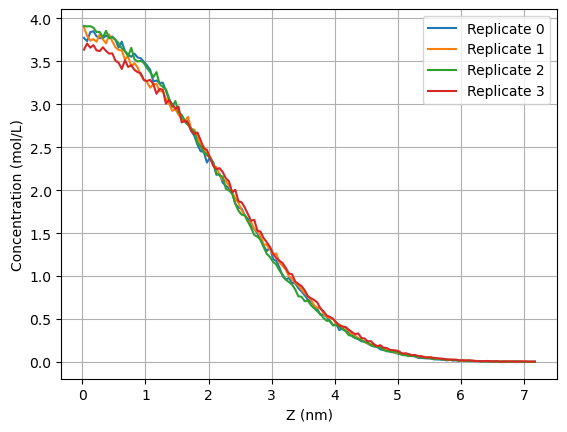

In [8]:
# Plot the concentration profiles (original and replicates)
plt.figure()
for i, c in enumerate(concentration_profiles):
    plt.plot(z, c, label="Replicate "+str(i))
plt.xlabel("Z (nm)")
plt.ylabel("Concentration (mol/L)")
plt.grid()
plt.legend()
plt.show()

## Calculating eq 12

$$ ln \left[ \frac{C_{s}(z)}{C_{max}} \right] + A \left[ \frac{C_{max}^{1/2}}{1+BC_{max}^{1/2}} - \frac{C_{s}(z)^{1/2}}{1+BC_{s}(z)^{1/2}} \right] + \sum^{i_{max}}_{i=1} \alpha_{i} [C_{s}(z)^{i} - C_{max}^{i}] = - \frac {U(z)}{RT}$$

In [9]:
def calc_y(theta, x):
    """
    Calculates -U(z) / RT using Equation 12.

    Parameters
    ----------
    theta : list
        A list containing the three parameters to be fit, including B, alpha_1, alpha_2.
    x : concentration list
    """
    A = 1.7964  # in M^(-1/2), value according to the SI

    # Converting the units for A so that they are nm-based
    conversion_factor = 1E24 / NA  # 1 nm^(-3) ~= 1.6605 M
    A /= (conversion_factor ** 0.5)

    C_max = np.max(x)
    term_1 = np.log(x / C_max)
    term_2 = -A * np.sqrt(x) / (1 + theta[0] * np.sqrt(x))
    term_3 = A * np.sqrt(C_max) / (1 + theta[0] * np.sqrt(C_max))
    term_4 = theta[1]* (x - C_max) 
    term_5 = theta[2] * (x ** 2 - C_max ** 2)
    y = term_1 + term_2 + term_3 + term_4 + term_5

    return y

def residuals(theta, x, y):
    return np.power(calc_y(theta, x) - y, 2)

In [10]:
#Use the direct average rather than over bootstrap means
mean_profile = np.mean(concentration_profiles,axis=0)
c_0 = mean_profile

# Removing 0 values from the concentration profile, and the corresponding z values
z_fit = z[c_0 != 0]
c_fit = c_0[c_0 != 0]

In [11]:
A = 1.7964  # in M^(-1/2), value according to the SI

# Converting the units for A so that they are nm-based
conversion_factor = 1E24 / NA  # 1 nm^(-3) ~= 1.6605 M
A /= (conversion_factor ** 0.5)

In [12]:
# Right side/ y of equation 12
y_values = -(0.5 * k * z_fit ** 2) * 1000 / (R * T) 

#Getting fit for full left side of eq 12
result_unweighted = least_squares(residuals, [4, 0.2, 0], args=(c_fit, y_values))

## Plotting unweighted results

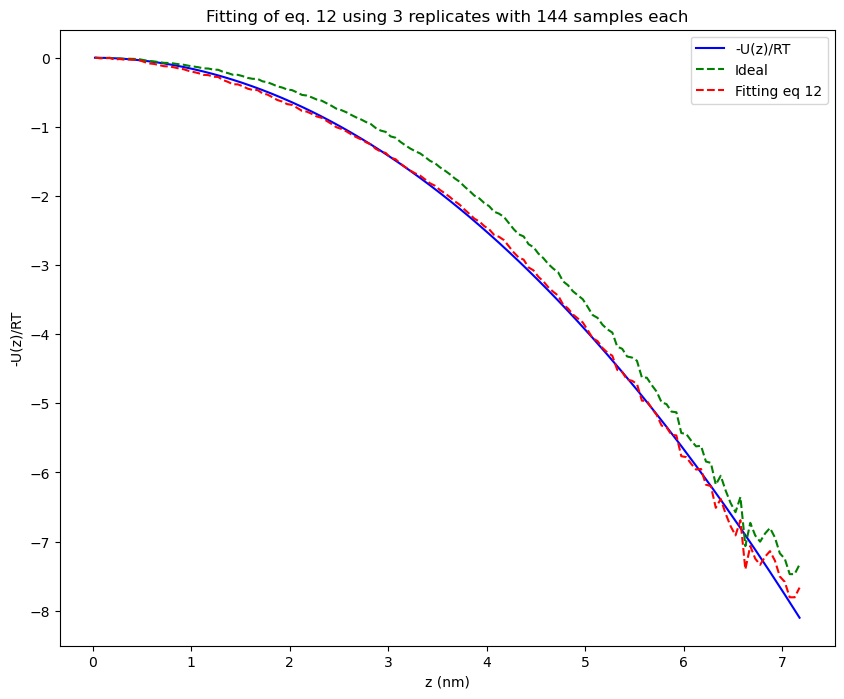

In [13]:
# plot the unweighted results
plt.figure(figsize = (10,8))
plt.plot(z_fit, y_values, 'b', label="-U(z)/RT")
plt.plot(z_fit, np.log(c_fit/np.max(c_fit)), 'g--', label="Ideal")
plt.plot(z_fit, calc_y(result_unweighted.x,c_fit), 'r--', label="Fitting eq 12")
plt.xlabel('z (nm)')
plt.ylabel('-U(z)/RT')
plt.title('Fitting of eq. 12 using 3 replicates with 144 samples each')
plt.legend()
plt.show()

We do see reasonably good fit - the idea curve (green line) is corrected to the be closer to the blue (red line is closer tothe blue line). However, we would also like to not fit the noise at the end. 

To do this, we do some error propagation to find the ideal weights for the least square fit. $C(z)/C_{max}$ is a probability, or at least proportional to a probability.  The uncertainty in a probability estimate $\hat{p}$ from a histogram (whose value with infinitely collected points would be $p$), can be shown to be $\sqrt{\frac{\hat{p}(1-\hat{p})}{n}}$, where $\hat{p}$ is the measured probability in that histogram bin, and $n$ is the total number of points collected over all bins.  But we are interested in the error of $\ln \hat{p}$. Generally the error in function $f$ of random variable $x$ $\delta f(x)$ is equal to $|f'(x)| \delta x$. So $\delta (\ln p) = \frac{\delta p}{p} = \sqrt{\frac{\hat{p}(1-\hat{p})}{n\hat{p}^2}}$.

For weighted least squares, it can be show that the weights should be proportional to 1/variance of the data point. The variance will be $(\delta\ln p)^2 = \frac{\hat{p}(1-\hat{p})}{n\hat{p}^2} = \frac{1-\hat{p}}{np}$.  The weights are only defined up to a constant, so we can just use $\frac{1-p}{p}$.  To do this, we have to normalize $C/C_{max}$, which is easy to do, we call it K. So the weights should be proportional to $\frac{C/K}{1-C/K} = \frac{C}{K-C}$.  So the most well defined points will get the most probability, the noisiest points the least.

## Find weights for least square fit

In [14]:
norm = N_s/(L_x*L_y)
print(norm)

9.416691316333331


In [15]:
def weighted_residuals(theta, x, y):
    return (x/(norm-x))*np.power(calc_y(theta, x) - y, 2)

In [16]:
#Getting fit for full left side of eq 12
result_weighted = least_squares(weighted_residuals, [4, 0.2,-0.01], args=(c_fit, y_values))

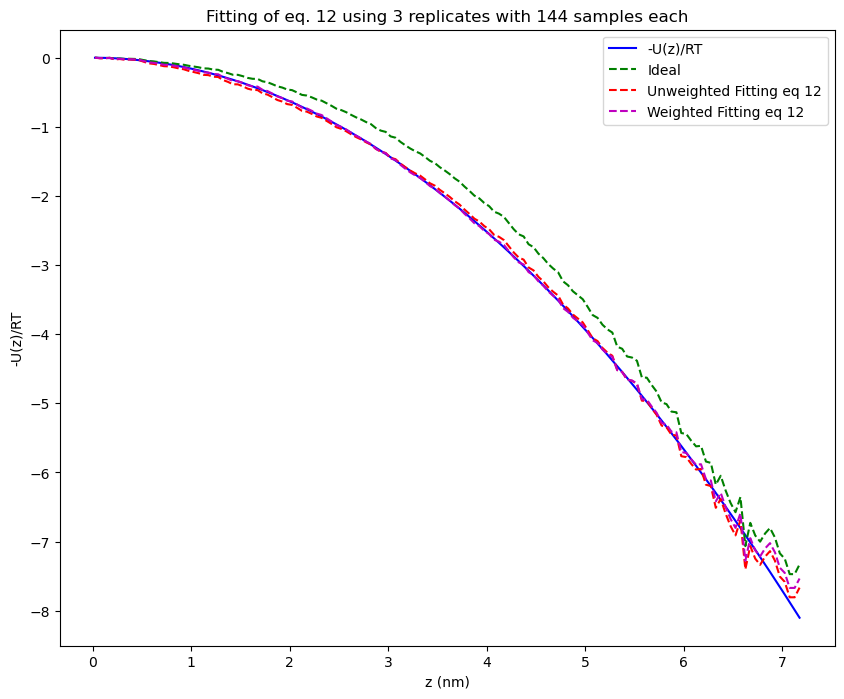

In [17]:
# plot the results
plt.figure(figsize = (10,8))
plt.plot(z_fit, y_values, 'b', label="-U(z)/RT")
plt.plot(z_fit, np.log(c_fit/np.max(c_fit)), 'g--', label="Ideal")
plt.plot(z_fit, calc_y(result_unweighted.x,c_fit), 'r--', label="Unweighted Fitting eq 12")
plt.plot(z_fit, calc_y(result_weighted.x,c_fit), 'm--', label="Weighted Fitting eq 12")
plt.xlabel('z (nm)')
plt.ylabel('-U(z)/RT')
plt.title('Fitting of eq. 12 using 3 replicates with 144 samples each')
plt.legend()
plt.show()

Hard to see what is going on, so let's look at differences

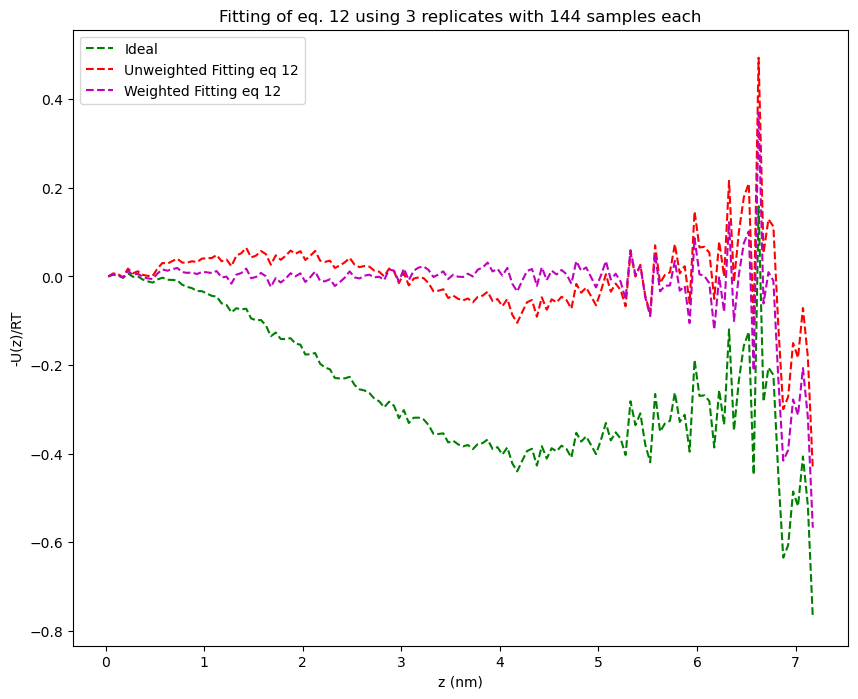

In [18]:
# plot the results. Notice the plots are now being subtracted from the y_values results
plt.figure(figsize = (10,8))
plt.plot(z_fit, y_values-np.log(c_fit/np.max(c_fit)), 'g--', label="Ideal")
plt.plot(z_fit, y_values-calc_y(result_unweighted.x,c_fit), 'r--', label="Unweighted Fitting eq 12")
plt.plot(z_fit, y_values-calc_y(result_weighted.x,c_fit), 'm--', label="Weighted Fitting eq 12")
plt.xlabel('z (nm)')
plt.ylabel('-U(z)/RT')
plt.title('Fitting of eq. 12 using 3 replicates with 144 samples each')
plt.legend()
plt.show()

The weighted fitting is much closer to zero over the range with reasonable concentrations, say z=5.

In [19]:
zlim = 4 #coordinate limit for where fitting is closer

In [20]:
#Stdev of unweighted results
np.std(y_values[z_fit<zlim]-calc_y(result_unweighted.x,c_fit[z_fit<zlim]))

0.03298181532693072

In [21]:
#Stdev of weighted results
np.std(y_values[z_fit<zlim]-calc_y(result_weighted.x,c_fit[z_fit<zlim]))

0.01040629169745181

Compare the distribution of the parameters with the fit!

In [22]:
print("B =", result_unweighted.x[0])
print("alpha1 =", result_unweighted.x[1])
print("alpha2 =", result_unweighted.x[2])

B = 22066.437298226414
alpha1 = -0.01060408206692025
alpha2 = 0.02592835184646411


In [23]:
print("B =", result_weighted.x[0])
print("alpha1 =", result_weighted.x[1])
print("alpha2 =", result_weighted.x[2])

B = 2.443326667548713
alpha1 = 0.2119531741911878
alpha2 = -0.01334231297027398


And we expect that the parameters will be more consistent between runs with weighting.

## Bootstrapping Profiles (without and with weights)

In [24]:
trialp = [4, 0.1,0.0]

In [25]:
# Function to perform bootstrapping
def bootstrap_profiles(profiles, n_samples, res_func):
    bootstrap_params = []
    n_profiles = len(profiles)
    for _ in range(n_samples):
        # Resample with replacement
        bootstrap_sample = [profiles[np.random.randint(0, n_profiles)] for _ in range(n_profiles)]
        # Calculate mean profile
        mean_profile = np.mean(bootstrap_sample, axis=0)
        z_fit = z[mean_profile != 0]
        c_fit = mean_profile[mean_profile != 0] 
        y_values = -(0.5 * k * z_fit ** 2) * 1000 / (R * T)
        result = least_squares(res_func, trialp, args=(c_fit, y_values))
        bootstrap_params.append(result.x)
        
    return np.array(bootstrap_params) # list

Param 0 = 12807.531937203807 +/- 15363.290499044317


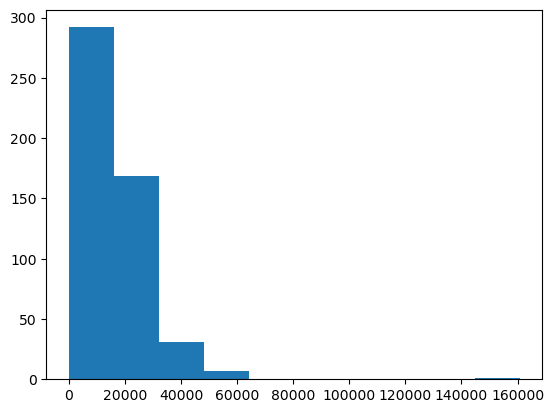

Param 1 = 0.2370440228603886 +/- 0.2724264205690806


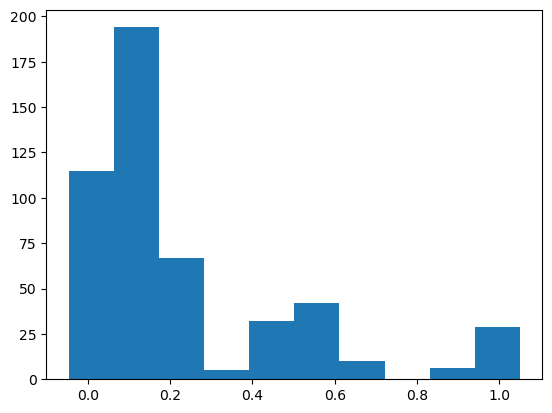

Param 2 = -0.01386026023943792 +/- 0.03414978235118376


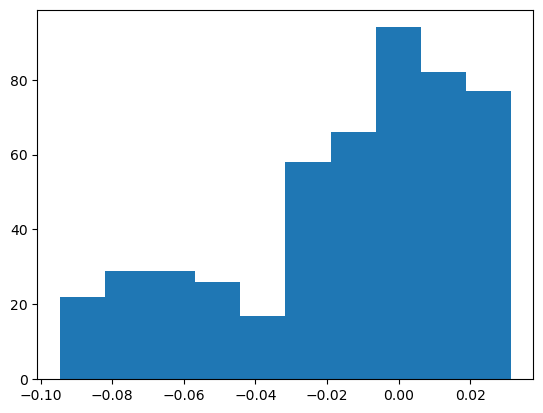

In [26]:
# Perform bootstrapping with unweighted fit
bootstrap_params_unweighted = bootstrap_profiles(profiles=concentration_profiles, n_samples=500, res_func=residuals)

for i in range(len(trialp)):
    pd = bootstrap_params_unweighted[:,i]
    std_param = np.std(pd) 
    mean_param = np.mean(pd)  # it's actually more accurate to
                             # just use the single fits, but we don't 
                             # necessarily know the name of that results structure
                             # when we are at this point in the code, use the mean for now
    print(f"Param {i} = {mean_param} +/- {std_param}")
    plt.hist(pd)
    plt.show()

Param 0 = 2.050809981657962 +/- 0.614260162808369


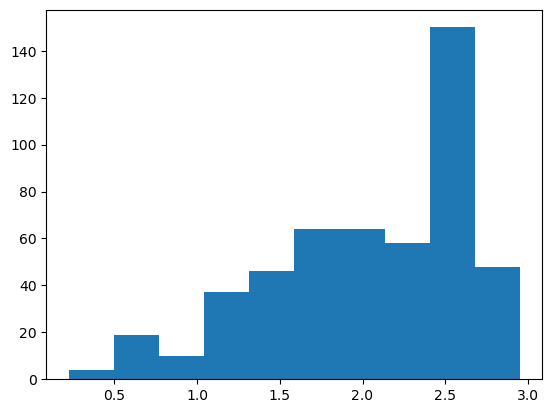

Param 1 = 0.2607725874781142 +/- 0.09418851627401734


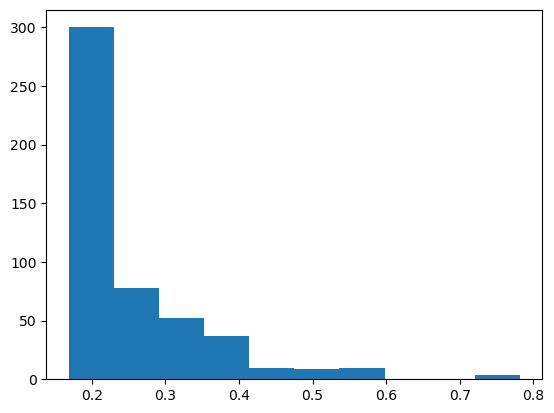

Param 2 = -0.020369213969160773 +/- 0.012347977015869175


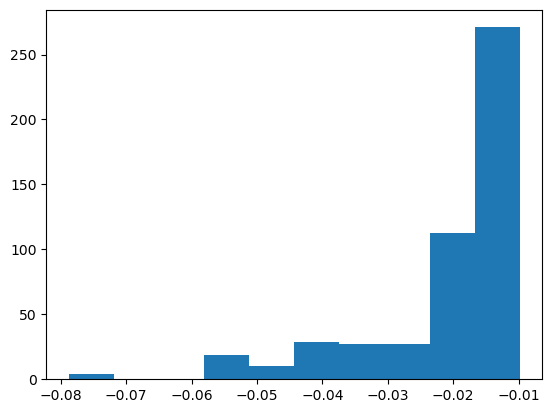

In [27]:
# Perform bootstrapping with weighted residuals
n_bootstrap = 500
bootstrap_params_weighted  = bootstrap_profiles(profiles=concentration_profiles, n_samples=500, res_func=weighted_residuals)

for i in range(len(trialp)):
    pd = bootstrap_params_weighted[:,i]
    std_param = np.std(pd) 
    mean_param = np.mean(pd)  # it's actually more accurate to
                             # just use the single fits, but we don't 
                             # necessarily know the name of that results structure
                             # when we are at this point in the code, use the mean for now
    print(f"Param {i} = {mean_param} +/- {std_param}")
    plt.hist(pd)
    plt.show()

Much more consistent performance!

## Maximum Likelihood Parameter Optimization

Now, we try maximum likelihood parameter optimization.  The basic idea is to express the probability of parameters given the data, $P(a|x)$, and using Bayes' rule to find that 

$P(a|x) = \frac{P(x|a)P(a)}{P(x)}$

We want to find the parameters 
$P(x)$ does not depend on the parameters. If we assume no prior information about the parameters $P(a)$ (that would be Bayesian inference), then we have.

$P(a|x) \propto P(x|a)$

So we need to maximize the probability given the data $P(\vec{x}|a)$. Assuming the samples are independent, then the total probability given all of the data is $\prod_{i=1}^N P(x_i|a)$.  

Since the logarithm is a monotonic function, then maximizing $\ln P(\vec{x}|a) = \sum_{i=1}^N \ln P(x_i|a)$ is the same as maximizing $P(\vec{x}|a$).

### The actual problem

We now apply the problem to the one of the chemical potential of ions trapped in a harmonic potential.

First, import the data.

In [28]:
import pickle
import pdb
import MDAnalysis as mda

In [29]:
u = mda.Universe('md.gro', 'md.xtc')
u.transfer_to_memory()
ions= u.select_atoms('resname SOD CLA')

u1 = mda.Universe('mdr1.gro', 'mdr1.xtc')
u1.transfer_to_memory()
ions1= u1.select_atoms('resname SOD CLA')

u2 = mda.Universe('mdr2.gro', 'mdr2.xtc')
u2.transfer_to_memory()
ions2= u2.select_atoms('resname SOD CLA')

u3 = mda.Universe('mdr3.gro', 'mdr3.xtc')
u3.transfer_to_memory()
ions3= u3.select_atoms('resname SOD CLA')

/home/bamo6610/miniconda3/envs/mdanalysis/lib/python3.10/site-packages/MDAnalysis/coordinates/XDR.py:240: UserWarning: Reload offsets from trajectory
 ctime or size or n_atoms did not match
  warnings.warn("Reload offsets from trajectory\n "


In [30]:
def get_ion_array(u,ions):
    ion_array=[]
    for ts in u.trajectory:
        ions_z = ions.positions[:,2]
        ion_array.append(ions_z)
    ionz = np.abs(np.array(ion_array)-72)/10  # rescale the data
    zvals=ionz.flatten()
    print(len(zvals))
    return zvals
zvals={}
zvals['original']=get_ion_array(u,ions)
zvals['r1']=get_ion_array(u1,ions1)
zvals['r2']=get_ion_array(u2,ions2)
zvals['r3']=get_ion_array(u3,ions3)


434434
434434
434434
434434


For this problem, we are essentially finding the parameters that examine the probability of finding an ion at a given $x$, since concentration is proportional to probability.  

We convert the concentration $C(z)/C_{max}$ to an unnormalized probability $p(z)$.  

$\ln p(z|B,\alpha_1,\alpha_2) \propto \ln \frac{C(z)}{C_{max}}$

$\ln \frac{C(z)}{C_{max}} = \sum_i -\frac{kz^2}{2RT} + A\left(\frac{C(z)^{1/2}}{1+BC(z)^{1/2}} - \frac{C_{max}^{1/2}}{1+BC_{max}^{1/2}} \right) -\alpha_1(C(z)-C_{max}) - \alpha_2(C(z)^2-C_{max}^2)$  



$C_{max}$ and also the normalizing constant will be fixed by the fact that we have a fixed number of ions present.

This is actually not ideal for maximizing, since the concentration $c(z)$ occurs on both sides. It would be great if we could algebraically solve for $c(z)$, but this does not appear to be possible.

We can't actually leave out any of the terms, because all of the terms involve the parameters implicitly (including $C_{max}$).

We approach the problem the following way:

 - Given a set $[B,\alpha_1,\alpha_2]$, find the concentration $C(z|B,\alpha_1,\alpha_2)$ that satisfies those parameters. 
 - This will need to be done self-consistently, as each time the parameters change, $C_{max}$ will also change.
 - We will make use of a reference ideal distribution with no parameters.


Define the ideal solution function which satisfies the normalization and find the $C_{max}$ for this solution, i.e. 

$N_p = L_x L_y C_{max} \int_0^{\infty} p(z|B,\alpha_1,\alpha_2) dz$

$C_{max} = \frac{ N_p }{L_x L_y} \left(\int_0^{\infty} p(z|B,\alpha_1,\alpha_2\right) dz )^{-1}$

In [31]:
from scipy.integrate import quad, simpson, trapezoid

In [32]:
red_U_app = lambda z: 1000*k*z*z/(2*R*T) #left side of eq 12
cz_ideal = lambda z: np.exp(-red_U_app(z)) 

#Should not hard code k

In [33]:
ideal_norm = quad(cz_ideal,0,10)[0]
print(ideal_norm)
ideal_norm = np.sqrt(np.pi*R*T/(2*1000*k))
print(ideal_norm)

#are we checking these both yield approx the same?
#where did the second equation come from? Why pi?

2.2341010940709776
2.2341011392922034


In [34]:
cmax_ideal=N_s/(L_x*L_y*ideal_norm)
print(cmax_ideal)

#same as cell above?

4.214979864034571


One issue is doing the integration of the model parameter to normalize it. 

We could try to take advantage of importance sampling - if we have two unnormalized probability distributions $q_i$ and $q_j$ ($p_i$ normalized), and we have samples from $q_i$, then we can have

$1 = \int p_j(z) dz \\
= \int \frac{p_j(z)}{p_i(z)}p_i(z) \\
= \int \frac{q_j(z)/Z_j}{q_i(z)/Z_i} p_i(z) \\
= \int \frac{Z_i}{Z_j} \frac{q_j(z)}{q_i(z)} p_i(z) \\
\approx \frac{Z_i}{Z_j} \frac{1}{N} \sum_n \frac{q_j(z_n)}{q_i(z_n)} \\
\frac{Z_i}{Z_j} \approx \frac{1}{N} \sum_n \frac{q_j(z_n)}{q_i(z_n)}
$

 So if we know the ideal solution normalizing factor, we can find

$Z_{trial} = Z_{ideal} \frac{1}{N} \sum_n \frac{q_{ideal}(z)}{q_{trial}(z)} =  Z_{ideal} \left \langle \frac{q_{ideal}(z)}{q_{trial}(z)} \right \rangle$

However, this doesn't actually appear work if we using this equation to optimize the parameters, because if we have a mismatch between the trial function and the data sampled; if the trial function functional form doesn't actually match the PDF measured, then we will continually get worse results.

Let's do something silly/simple and assume we have enough data, and just take the points that are output, and do Simpson's rule on those.

In [35]:
# define a function that iterates the calculation of a concentration.
def czfunc(a,z,cz):
    # exponential of eq 12 for ln c/cmax for the data points
    cznew = np.exp(logprobfunc(a,z,cz))
    # these indices do not need to be repeated if this is expensive,
    # but if we bootstrap, they will change, so keep for now. 
    zunique,locs = np.unique(z,return_index=True)
    # now we have sorted unique points, we can integrate
    newarea = simpson(cznew[locs],zunique)
    cznorm_ratio = ideal_norm/newarea
    return (cmax_ideal*cznorm_ratio)*cznew

In [36]:
def logprobfunc(a,z,cz,A=A):
    # we need to calculate the maximum concentration 
    cmax = np.max(cz) # this only works if a sample is at z=0: improve!                      
    czh = np.sqrt(cz)
    cmaxh = np.sqrt(cmax)
    term_1 = -red_U_app(z)
    term_2 = A*((czh/(1+a[0]*czh))-(cmaxh/(1+a[0]*cmaxh)))
    term_3 = - a[1]*(cz - cmax)
    term_4 = - a[2]*(cz**2 - cmax**2)
    return term_1 + term_2 + term_3 + term_4

In [37]:
def converge_c(params, z, cz_start,
               niter=1000,lim=0.0001,verbose=False):

    # hot start from ideal, otherwise use a good guess.
    if isinstance(cz_start,str):
        if cz_start == 'ideal':
            cz_start = cmax_ideal*cz_ideal(z)
            
    c_old = cz_start
    for i in range(niter):
        c_new = czfunc(params,z,c_old)
        norm = np.sqrt(np.dot(c_new-c_old,c_new-c_old))
        if verbose:
            print(i,norm)
        c_old = c_new
        if norm < lim:
            break

    return czfunc(params,z,c_new)

How many duplicates of each $z$ value are there?  

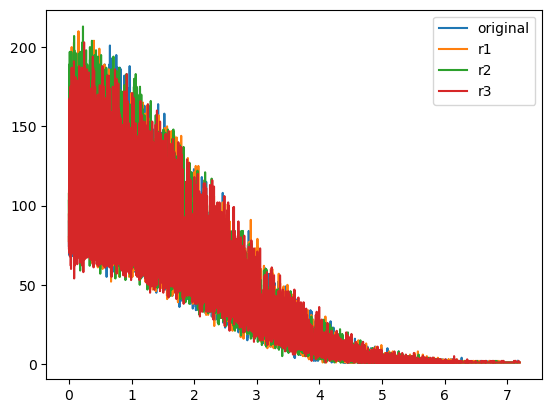

In [38]:
zsparse_o,zcount_o=np.unique(zvals['original'],return_counts=True)
zsparse_r1,zcount_r1=np.unique(zvals['r1'],return_counts=True)
zsparse_r2,zcount_r2=np.unique(zvals['r2'],return_counts=True)
zsparse_r3,zcount_r3=np.unique(zvals['r3'],return_counts=True)
plt.plot(zsparse_o,zcount_o,label='original')
plt.plot(zsparse_r1,zcount_r1,label='r1')
plt.plot(zsparse_r2,zcount_r2,label='r2')
plt.plot(zsparse_r3,zcount_r3,label='r3')
plt.legend()
plt.show()

Turns out, quite a few!  We can take advantage of that; each time the same $z$ is processed, it would result in the same number, so we can calculate the contribution for each $z$ once and then mulitply by the number of times it appears.

/tmp/ipykernel_200423/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 7.1580000e+00 7.1599998e+00
 7.1719999e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


0 116.26807
1 12.6839075
2 2.1388824
3 0.38846645
4 0.07399595
5 0.0144402385
6 0.0028960763
7 0.000599404
0 115.633965


/tmp/ipykernel_200423/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 7.1640000e+00 7.1760011e+00
 7.1980004e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


1 12.623543
2 2.1349602
3 0.38940805
4 0.07501375
5 0.015222095
6 0.0031304639
7 0.0017165281
8 0.0011393564
9 0.00019341704


/tmp/ipykernel_200423/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 7.1789999e+00 7.1910005e+00
 7.1930008e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


0 116.31085
1 12.66279
2 2.1364632
3 0.38874692
4 0.07454536
5 0.014410976
6 0.0028809079
7 0.0011795523
8 0.00048113498


/tmp/ipykernel_200423/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 7.1879997e+00 7.1919999e+00
 7.1990004e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


0 114.942
1 12.686057
2 2.1476572
3 0.39159456
4 0.07555007
5 0.015388994
6 0.003328301
7 0.0010700583
8 0.0011588369
9 0.000915185


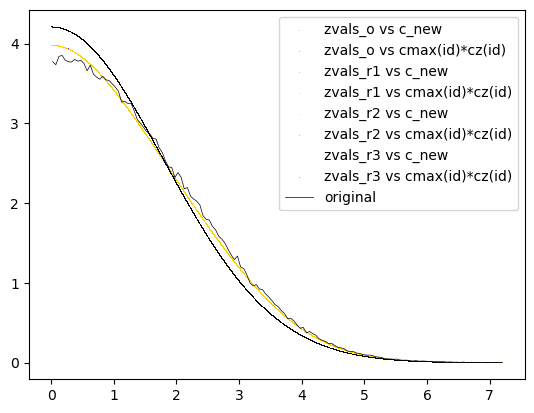

In [41]:
newp = np.array([1.35,0.33,-0.04])
c_new_o = converge_c(newp,zvals['original'],cz_start='ideal',lim=0.001,verbose=True)
c_new_r1 = converge_c(newp,zvals['r1'],cz_start='ideal',lim=0.001,verbose=True)
c_new_r2 = converge_c(newp,zvals['r2'],cz_start='ideal',lim=0.001,verbose=True)
c_new_r3 = converge_c(newp,zvals['r3'],cz_start='ideal',lim=0.001,verbose=True)
plt.scatter(zvals['original'],c_new_o,s=0.1,lw=0.1,c='m', label='zvals_o vs c_new')
plt.scatter(zvals['original'],cmax_ideal*cz_ideal(zvals['original']),s=0.1,lw=0.1,c='b', label='zvals_o vs cmax(id)*cz(id)')
plt.scatter(zvals['r1'],c_new_r1,s=0.1,lw=0.1,c='r', label='zvals_r1 vs c_new')
plt.scatter(zvals['r1'],cmax_ideal*cz_ideal(zvals['r1']),s=0.1,lw=0.1,c='c', label='zvals_r1 vs cmax(id)*cz(id)')
plt.scatter(zvals['r2'],c_new_r2,s=0.1,lw=0.1,c='darkorange', label='zvals_r2 vs c_new')
plt.scatter(zvals['r2'],cmax_ideal*cz_ideal(zvals['r2']),s=0.1,lw=0.1,c='indigo', label='zvals_r2 vs cmax(id)*cz(id)')
plt.scatter(zvals['r3'],c_new_r3,s=0.1,lw=0.1,c='gold', label='zvals_r3 vs c_new')
plt.scatter(zvals['r3'],cmax_ideal*cz_ideal(zvals['r3']),s=0.1,lw=0.1,c='black', label='zvals_r3 vs cmax(id)*cz(id)')
plt.plot(z,concentration_profiles[0],'k',lw=0.5, label='original')
plt.legend()
plt.show()

/tmp/ipykernel_200423/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 7.1580000e+00 7.1599998e+00
 7.1719999e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)
/tmp/ipykernel_200423/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 7.1640000e+00 7.1760011e+00
 7.1980004e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)
/tmp/ipykernel_200423/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 7.1789999e+00 7.1910005e+00
 7.1930008e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 

0 14.368908
1 1.6693057
2 0.2842004
3 0.05206415
4 0.009977741
5 0.0019627505
6 0.00039552708
0 14.369344
1 1.6692829
2 0.2841857
3 0.05211789
4 0.010033362
5 0.0020109375
6 0.0004097087
0 14.369347
1 1.6693138
2 0.2842231
3 0.052112177
4 0.0100161955
5 0.0019607318
6 0.00039437498
0 14.369645
1 1.6693201
2 0.28417647
3 0.052088056
4 0.010036014
5 0.0020170843
6 0.00042531802


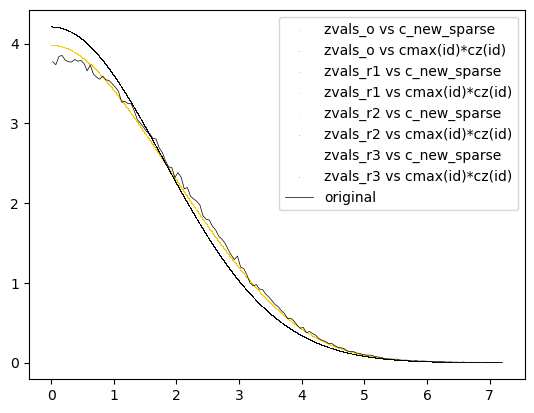

In [42]:
# we can converge faster with sparse data. (?)
c_new_sparse_o = converge_c(newp,zsparse_o,cz_start='ideal',lim=0.001,verbose=True)
c_new_sparse_r1 = converge_c(newp,zsparse_r1,cz_start='ideal',lim=0.001,verbose=True)
c_new_sparse_r2 = converge_c(newp,zsparse_r2,cz_start='ideal',lim=0.001,verbose=True)
c_new_sparse_r3 = converge_c(newp,zsparse_r3,cz_start='ideal',lim=0.001,verbose=True)
plt.scatter(zsparse_o,c_new_sparse_o,s=0.1,lw=0.1,c='m', label='zvals_o vs c_new_sparse')
plt.scatter(zsparse_o,cmax_ideal*cz_ideal(zsparse_o),s=0.1,lw=0.1,c='b', label='zvals_o vs cmax(id)*cz(id)')
plt.scatter(zsparse_r1,c_new_sparse_r1,s=0.1,lw=0.1,c='r', label='zvals_r1 vs c_new_sparse')
plt.scatter(zsparse_r1,cmax_ideal*cz_ideal(zsparse_r1),s=0.1,lw=0.1,c='c', label='zvals_r1 vs cmax(id)*cz(id)')
plt.scatter(zsparse_r2,c_new_sparse_r2,s=0.1,lw=0.1,c='darkorange', label='zvals_r2 vs c_new_sparse')
plt.scatter(zsparse_r2,cmax_ideal*cz_ideal(zsparse_r2),s=0.1,lw=0.1,c='indigo', label='zvals_r2 vs cmax(id)*cz(id)')
plt.scatter(zsparse_r3,c_new_sparse_r3,s=0.1,lw=0.1,c='gold', label='zvals_r3 vs c_new_sparse')
plt.scatter(zsparse_r3,cmax_ideal*cz_ideal(zsparse_r3),s=0.1,lw=0.1,c='black', label='zvals_r3 vs cmax(id)*cz(id)')
plt.plot(z,concentration_profiles[0],'k',lw=0.5, label='original')
plt.legend()
plt.show()

In [43]:
def neglliter(a,z,cz_start,counts=None,lim=0.0001,verbose=False,print_val=False,doeval=False):
    if len(z)!= len(cz_start):
        print("x and y data does not match length")
        return
    if doeval == True:
        lim = 1
    # generate the new concentration with these parameters
    cz = converge_c(a,z,cz_start,lim=lim,verbose=verbose)
    # divide by cmax_ideal to make the numbers smaller, 
    # it's a constant so it doesn't affect the results     
    terms = np.log(cz/cmax_ideal)
    # if we don't know how many of each value there are,
    # just add them all up
    if counts is None:
        csum = np.sum(terms)
    else:
        # if we DO know how many of each value there are
        # then just do each value once, and multiply
        # by the number of counts
        csum = np.dot(counts,terms)
    if print_val:
        print("csum",csum)
    return -1*csum

In [44]:
from timeit import default_timer as timer

Note we can make this much faster by noting that there are a lot of repeats of each value, so we can simplify the sum (MIGHT be slightly different because of rounding).


In [45]:
# this is now much faster, and gives essentially the same answer.
start = timer()
results = minimize(neglliter,newp,args=(zsparse_o,c_new_sparse_o,zcount_o),method='Nelder-Mead')
end = timer()
print("time=",end-start)
print(results)
full_opt = results.x

/tmp/ipykernel_200423/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 7.1580000e+00 7.1599998e+00
 7.1719999e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


time= 2.602931714965962
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 240786.7533433661
             x: [ 1.396e+00  2.596e-01 -2.181e-02]
           nit: 89
          nfev: 201
 final_simplex: (array([[ 1.396e+00,  2.596e-01, -2.181e-02],
                       [ 1.396e+00,  2.596e-01, -2.181e-02],
                       [ 1.396e+00,  2.596e-01, -2.181e-02],
                       [ 1.396e+00,  2.596e-01, -2.181e-02]]), array([ 2.408e+05,  2.408e+05,  2.408e+05,  2.408e+05]))


/tmp/ipykernel_200423/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 7.1580000e+00 7.1599998e+00
 7.1719999e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)
/tmp/ipykernel_200423/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 7.1640000e+00 7.1760011e+00
 7.1980004e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)
/tmp/ipykernel_200423/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 7.1789999e+00 7.1910005e+00
 7.1930008e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 

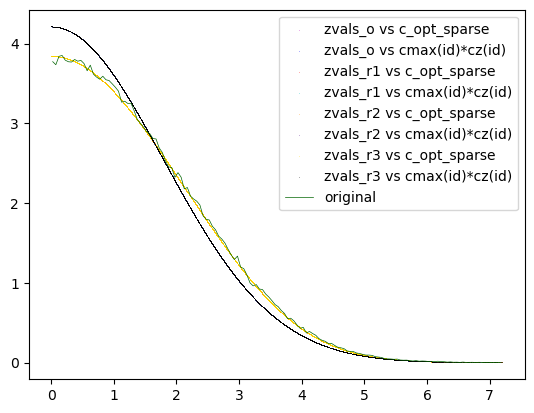

In [50]:
# now plot the new data 
c_opt_sparse_o = converge_c(results.x,zsparse_o,cz_start=c_new_sparse_o,verbose=False)
c_opt_sparse_r1 = converge_c(results.x,zsparse_r1,cz_start=c_new_sparse_r1,verbose=False)
c_opt_sparse_r2 = converge_c(results.x,zsparse_r2,cz_start=c_new_sparse_r2,verbose=False)
c_opt_sparse_r3 = converge_c(results.x,zsparse_r3,cz_start=c_new_sparse_r3,verbose=False)
plt.scatter(zsparse_o,c_opt_sparse_o,s=0.1,lw=0.1,c='m', label='zvals_o vs c_opt_sparse')
plt.scatter(zsparse_o,cmax_ideal*cz_ideal(zsparse_o),s=0.1,lw=0.1,c='b', label='zvals_o vs cmax(id)*cz(id)')
plt.scatter(zsparse_r1,c_opt_sparse_r1,s=0.1,lw=0.1,c='r', label='zvals_r1 vs c_opt_sparse')
plt.scatter(zsparse_r1,cmax_ideal*cz_ideal(zsparse_r1),s=0.1,lw=0.1,c='c', label='zvals_r1 vs cmax(id)*cz(id)')
plt.scatter(zsparse_r2,c_opt_sparse_r2,s=0.1,lw=0.1,c='darkorange', label='zvals_r2 vs c_opt_sparse')
plt.scatter(zsparse_r2,cmax_ideal*cz_ideal(zsparse_r2),s=0.1,lw=0.1,c='indigo', label='zvals_r2 vs cmax(id)*cz(id)')
plt.scatter(zsparse_r3,c_opt_sparse_r3,s=0.1,lw=0.1,c='gold', label='zvals_r3 vs c_opt_sparse')
plt.scatter(zsparse_r3,cmax_ideal*cz_ideal(zsparse_r3),s=0.1,lw=0.1,c='black', label='zvals_r3 vs cmax(id)*cz(id)')
plt.plot(z,concentration_profiles[0],'darkgreen',lw=0.5, label='original')
plt.legend()
plt.show()

Note that the parameters are somewhat different, but the curves are about the same; the space appears to be relatively degenerate, in that there's a large volume of parameters that all give similar results. But that's probably OK for osmotic coefficients, as there will also be many parameters that thus give about the same osmotic coefficient. 

This seems to work!  Things to do:

1. Implement bootstrapping. A key here is one can now bootstrap over all the SAMPLES (like 188,000), not the profiles (4).
2. See what happens when you use all the data from the trajectories.  You can just dump them all into one big array - the bootstrapping is on samples, not on the trajectories.
3. See if you can get away with 2 paramters, not 3, and still get a good fit.  
4. Bootstrap around the osmotic coefficient/pressure calculation given the curve - this will be much less noisy than the parameters themselves. 


In [51]:
# Function to perform bootstrapping over _samples_
def bootstrap_samples(samples, n_boot, minfunc, init_params):
    zinit=np.unique(samples)
    c_start = converge_c(init_params,zinit,cz_start='ideal',verbose=False)
    bootstrap_params = list()
    bootstrap_cs = list()
    n_samples = len(samples)
    for i in range(n_boot):
        # Resample with replacement
        indices = np.random.randint(0,n_samples,size=n_samples)
        bootstrap_sample = samples[indices]
        zsparse,zcount=np.unique(bootstrap_sample,return_counts=True)
        # we can't use the old concentrations since they are at potentially different z
        # so interpolate (should be negligible error)
        c_new = np.interp(zsparse,zinit,c_start)
        result = minimize(minfunc,init_params,args=(zsparse,c_new,zcount),method="Nelder-Mead")
        print(i,result.x,result.fun)
        bootstrap_params.append(result.x)
        # generate a converged concentration at this point. Make the locations
        # at the same points as the original
        c_new = converge_c(result.x,zsparse,cz_start=c_new)
        c_new = np.interp(zinit,zsparse,c_new)
        bootstrap_cs.append(c_new) 
    return np.array(bootstrap_params), np.array(bootstrap_cs)

In [54]:
zvals_all=[
    *zvals['original'],
    *zvals['r1'],
    *zvals['r2'],
    *zvals['r3'],
]

In [66]:
print(type(zvals_all))

<class 'list'>


In [67]:
zvals_all=np.array(zvals_all)

In [68]:
bparams,bcs = bootstrap_samples(zvals_all,500,neglliter,results.x)

/tmp/ipykernel_200423/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 7.1930008e+00 7.1980004e+00
 7.1990004e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


0 [ 2.73727098  0.18429862 -0.01005581] 984653.9778858483


/tmp/ipykernel_200423/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 7.1800017e+00 7.1910005e+00
 7.1930008e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


1 [ 3.00149993  0.15991813 -0.00515063] 984718.4109739732


/tmp/ipykernel_200423/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 7.1910005e+00 7.1930008e+00
 7.1980004e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


2 [ 2.79696045  0.17725452 -0.0085208 ] 985030.1008578198


/tmp/ipykernel_200423/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 7.1910005e+00 7.1980004e+00
 7.1990004e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


3 [ 2.87989908  0.16804647 -0.00676997] 984408.7862287074


/tmp/ipykernel_200423/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 7.1910005e+00 7.1919999e+00
 7.1990004e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


4 [ 3.08091127  0.15483814 -0.00455266] 983370.8614281198


/tmp/ipykernel_200423/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 7.1910005e+00 7.1919999e+00
 7.1980004e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


5 [ 2.68786371  0.17457238 -0.00792547] 982763.4459618429


/tmp/ipykernel_200423/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 7.1919999e+00 7.1980004e+00
 7.1990004e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


6 [ 2.55442361  0.18551936 -0.00962975] 984026.8753179082
7 [ 2.75457902  0.17601336 -0.00839088] 983512.0729456354


/tmp/ipykernel_200423/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 7.1760011e+00 7.1800017e+00
 7.1930008e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


8 [ 2.61762248  0.1787612  -0.00834163] 983834.8671669316
9 [ 2.73423495  0.1713892  -0.00723207] 983235.732171751


/tmp/ipykernel_200423/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 7.1879997e+00 7.1919999e+00
 7.1930008e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


10 [ 2.7146962   0.17885669 -0.00862857] 984432.9816947386


/tmp/ipykernel_200423/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 7.1809998e+00 7.1980004e+00
 7.1990004e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


11 [ 2.90496001  0.16674572 -0.00614786] 985898.8669625483


/tmp/ipykernel_200423/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 7.1919999e+00 7.1930008e+00
 7.1980004e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


12 [ 2.81696872  0.16869913 -0.00709535] 982753.3975317143


/tmp/ipykernel_200423/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 7.1800017e+00 7.1809998e+00
 7.1879997e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


13 [ 2.83405152  0.17315742 -0.0078535 ] 984181.0521919047


/tmp/ipykernel_200423/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 7.1910005e+00 7.1919999e+00
 7.1930008e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


14 [ 2.91339487  0.1747636  -0.00839241] 984878.4039051164
15 [ 2.36209604  0.19692369 -0.01068468] 986319.9386072769


/tmp/ipykernel_200423/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 7.1879997e+00 7.1910005e+00
 7.1930008e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


16 [ 2.74033836  0.1781113  -0.00876389] 983812.2160043989
17 [ 3.11946974  0.16197669 -0.00608394] 984711.4596996569
18 [ 2.79231288  0.17319212 -0.0075128 ] 984828.5306466598
19 [ 2.8474886   0.17104633 -0.00721088] 984970.9552633195


/tmp/ipykernel_200423/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 7.1809998e+00 7.1930008e+00
 7.1990004e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


20 [ 2.55890773  0.19215977 -0.0111651 ] 984416.1402151071
21 [ 2.99273184  0.16569511 -0.00655072] 984712.0076499862
22 [ 2.89129819  0.17496373 -0.00884013] 983140.8764390062
23 [ 3.17636961  0.16238046 -0.00656734] 984017.2018284111
24 [ 2.19952837  0.21427638 -0.01451418] 983827.5242884853


/tmp/ipykernel_200423/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 7.1919999e+00 7.1930008e+00
 7.1990004e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


25 [ 3.15042035  0.15498548 -0.00445889] 984772.8408053425
26 [ 3.02703951  0.16742303 -0.007453  ] 983314.5209836415
27 [ 2.54477813  0.1873212  -0.01013718] 983544.2074515977
28 [ 2.64433286  0.17717017 -0.00790762] 984432.3162267581
29 [ 2.55413873  0.19040357 -0.01095055] 983381.0821812283


/tmp/ipykernel_200423/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 7.1879997e+00 7.1930008e+00
 7.1980004e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


30 [ 2.69239038  0.18024871 -0.00907528] 983737.0913959746
31 [ 2.67980549  0.17853335 -0.00833012] 984913.7543517282
32 [ 3.21976128  0.15389292 -0.00498872] 982654.7239445533
33 [ 2.89612731  0.1686562  -0.00718206] 983501.1503311142
34 [ 2.6440601   0.18463488 -0.00948329] 985487.0761539037
35 [ 3.19955682  0.16454113 -0.00667613] 985880.2768485472
36 [ 2.86320073  0.16973003 -0.00739191] 983320.1811792806


/tmp/ipykernel_200423/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 7.1809998e+00 7.1930008e+00
 7.1980004e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


37 [ 2.5345622   0.18875393 -0.01070911] 982482.7027746063


/tmp/ipykernel_200423/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 7.1809998e+00 7.1879997e+00
 7.1910005e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


38 [ 2.57844814  0.19077115 -0.0107325 ] 985143.1932414692
39 [ 2.9419395   0.17184209 -0.00796567] 984287.1979773269


/tmp/ipykernel_200423/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 7.1800017e+00 7.1879997e+00
 7.1930008e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


40 [ 2.76124411  0.1681371  -0.00632096] 984196.0234038859
41 [ 2.84000084  0.16783095 -0.00666712] 983825.0092229493


/tmp/ipykernel_200423/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 7.1809998e+00 7.1879997e+00
 7.1919999e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


42 [ 2.76969912  0.17353497 -0.00797345] 983038.3260180767


/tmp/ipykernel_200423/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 7.1910005e+00 7.1930008e+00
 7.1990004e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


43 [ 3.10183614  0.16595943 -0.00678726] 985553.6191574214
44 [ 2.61970208  0.18169471 -0.00916388] 983435.7029816939
45 [ 3.29013678  0.15964128 -0.00623618] 984122.0012292876
46 [ 2.91399775  0.16703946 -0.00657808] 984687.1746950041
47 [ 2.54852411  0.17983355 -0.00849376] 982913.7209999393
48 [ 2.4674717   0.19408991 -0.01120598] 984253.2635974823


/tmp/ipykernel_200423/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 7.1809998e+00 7.1919999e+00
 7.1980004e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


49 [ 2.7413187   0.1794822  -0.00916906] 983456.7376532537
50 [ 2.76767839  0.17757137 -0.00834619] 985365.2009525263
51 [ 2.48452415  0.18929295 -0.01010112] 984255.6470721744
52 [ 2.81219577  0.17332192 -0.00764966] 984792.7724570584
53 [ 2.52319319  0.19410057 -0.01150565] 984130.5073787861
54 [ 2.55374269  0.17659931 -0.00783643] 982477.0440175915
55 [ 3.10599667  0.15422512 -0.00416803] 984554.758466539
56 [ 3.05676358  0.1678634  -0.00756118] 983808.2521287483
57 [ 2.73738738  0.17243051 -0.00751302] 983300.061960189


/tmp/ipykernel_200423/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 7.1809998e+00 7.1910005e+00
 7.1919999e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


58 [ 2.94183595  0.16806834 -0.00695702] 984613.921177808
59 [ 2.62734865  0.18530705 -0.00981367] 984463.2533258464
60 [ 2.43817133  0.18957456 -0.01037264] 982574.0975837444
61 [ 2.71865276  0.17715606 -0.00842574] 983936.0286508923
62 [ 2.87392525  0.17315309 -0.0079692 ] 984516.2813470997
63 [ 2.97439562  0.16966394 -0.00743201] 984648.4962156055
64 [ 2.90631777  0.17526505 -0.00837161] 985518.6788095005
65 [ 3.27263581  0.16159145 -0.00622293] 985716.7712034666
66 [ 2.80958551  0.16878854 -0.0068334 ] 983665.6790318823
67 [ 2.92093434  0.16881857 -0.00705879] 984568.9477640963
68 [ 2.81629637  0.16606154 -0.0063617 ] 983092.2446244953
69 [ 2.68947075  0.1765347  -0.00834768] 983044.5166128628
70 [ 2.55170204  0.18581102 -0.00958903] 984421.561501199
71 [ 2.8556601   0.17342607 -0.00827705] 983374.544416911
72 [ 2.43746363  0.19116967 -0.0101251 ] 985005.0107975769
73 [ 2.8261721   0.18103642 -0.00951513] 985126.0015744031
74 [ 2.79967189  0.17902586 -0.00877131] 985567.5764392737


/tmp/ipykernel_200423/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 7.1719999e+00 7.1800017e+00
 7.1980004e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


80 [ 2.98401941  0.1690409  -0.00761111] 983616.4639816054
81 [ 2.72921474  0.17677901 -0.00838966] 983806.5101432247
82 [ 2.66599087  0.18244676 -0.0092952 ] 984535.7958306292


/tmp/ipykernel_200423/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 7.1879997e+00 7.1980004e+00
 7.1990004e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


83 [ 2.64692826  0.18386851 -0.00990356] 983067.4649723956
84 [ 2.55439495  0.18917913 -0.01041726] 984476.3783125036


/tmp/ipykernel_200423/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 7.1879997e+00 7.1910005e+00
 7.1990004e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


85 [ 2.62883324  0.18133894 -0.0091526 ] 983375.1009888032
86 [ 2.51035747  0.18832719 -0.01020219] 983484.6009258904


/tmp/ipykernel_200423/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 7.1800017e+00 7.1879997e+00
 7.1990004e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


87 [ 2.93832316  0.16722195 -0.00695647] 983704.4140588951
88 [ 2.85077527  0.1694047  -0.00701495] 984127.9286246798
89 [ 2.85487451  0.16779503 -0.00680762] 983614.3522082487
90 [ 2.71581299  0.17386619 -0.00752738] 984055.7881708591
91 [ 2.99982335  0.16572033 -0.00642012] 985280.4723813747
92 [ 2.95134851  0.17498262 -0.00880106] 984205.3121262531
93 [ 3.30754374  0.15908391 -0.0062614 ] 983682.9647715886
94 [ 2.96884118  0.1670118  -0.00688957] 984255.49185049
95 [ 2.47062728  0.18967319 -0.01027709] 983642.3590970789


/tmp/ipykernel_200423/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 7.1879997e+00 7.1919999e+00
 7.1980004e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


96 [ 2.65016503  0.18200319 -0.00907277] 984659.6329081348
97 [ 2.82995407  0.18081993 -0.00954877] 984844.6717513481
98 [ 2.70691861  0.1783999  -0.00839216] 984965.6635168579
99 [ 2.59001114  0.18259124 -0.00932502] 983111.6057697523
100 [ 2.68614598  0.17136899 -0.00730075] 982164.9701668324
101 [ 2.59344359  0.18579221 -0.00993495] 983839.1378437565
102 [ 2.95364155  0.16409013 -0.00601725] 984691.2036338433


/tmp/ipykernel_200423/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 7.1879997e+00 7.1930008e+00
 7.1990004e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


103 [ 2.3360324   0.19955029 -0.01165352] 984684.8676821906
104 [ 2.94421341  0.17471551 -0.00861326] 984486.4598440806
105 [ 2.78219135  0.17983673 -0.00942013] 983648.0914570966
106 [ 3.05393323  0.16305604 -0.00632519] 983834.6269693313
107 [ 3.0389821   0.16601472 -0.00673357] 984794.4183170644


/tmp/ipykernel_200423/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 7.1809998e+00 7.1910005e+00
 7.1990004e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


108 [ 2.70426326  0.17836562 -0.00837726] 984884.3172458453
109 [ 3.00962514  0.16616902 -0.00663817] 984989.1580309902
110 [ 2.67871319  0.17525122 -0.00825099] 982005.5075857987
111 [ 2.67507425  0.17664262 -0.0080236 ] 983993.5454716965
112 [ 2.49376562  0.19004909 -0.01025328] 984510.8040643646
113 [ 2.56540607  0.18898859 -0.01021547] 985306.5986907466
114 [ 2.63183302  0.17969355 -0.00861596] 983933.6696651881
115 [ 2.55605502  0.19106869 -0.01088442] 984509.6263329806
116 [ 2.70402223  0.1784241  -0.00853553] 984436.8510199551
117 [ 2.53137479  0.18153972 -0.0087336 ] 983259.1148157069


/tmp/ipykernel_200423/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 7.1800017e+00 7.1919999e+00
 7.1990004e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


118 [ 2.85091067  0.16529661 -0.00601076] 984203.4193241053
119 [ 2.39966535  0.19160818 -0.01041243] 983367.1048793708
120 [ 3.35695819e+00  1.48069262e-01 -3.15505497e-03] 985742.4702285806
121 [ 2.90466358  0.17253122 -0.00765201] 985527.8285307508
122 [ 2.8109974   0.17197448 -0.00763957] 983577.9660894726
123 [ 2.82934251  0.1834997  -0.00994181] 985861.9450217569
124 [ 2.39930271  0.19859288 -0.01204961] 983664.4486494988
125 [ 2.75042641  0.17713685 -0.00835817] 984731.5041069796
126 [ 2.59737895  0.18502402 -0.00959258] 984460.5179215225


/tmp/ipykernel_200423/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 7.1809998e+00 7.1879997e+00
 7.1980004e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


127 [ 2.29790308  0.20054131 -0.01181758] 984001.9242015211
128 [ 2.6158654   0.18311149 -0.00913932] 984960.5730347994
129 [ 2.78302607  0.17253983 -0.00786298] 982813.9589065138
130 [ 2.57041264  0.1882912  -0.01028818] 984413.1700774976
131 [ 3.27722311  0.15865914 -0.00553194] 985735.4027214689
132 [ 2.54705052  0.18704647 -0.01037077] 982397.0443832116
133 [ 2.51675438  0.18035848 -0.00824199] 983617.3713369926
134 [ 2.79143336  0.16841146 -0.00680051] 983234.4640166906
135 [ 3.0052854   0.16920147 -0.00758397] 984203.9424163261
136 [ 2.80219528  0.17858204 -0.00923485] 983432.8239403949
137 [ 2.74947869  0.17719643 -0.00847663] 984391.0824915131
138 [ 2.78498091  0.17257663 -0.00759226] 983935.5462604025
139 [ 2.83221653  0.171423   -0.00724401] 984873.7480453188


/tmp/ipykernel_200423/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 7.1809998e+00 7.1919999e+00
 7.1930008e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


140 [ 3.02052829  0.16367393 -0.00640914] 983615.0815352603
141 [ 2.34206505  0.20555685 -0.01329703] 984060.4887354648
142 [ 2.64004015  0.1830555  -0.00962426] 983366.0972171437
143 [ 2.99192536  0.17041372 -0.00793007] 983721.4361828293
144 [ 3.08202366  0.16235187 -0.00626399] 983889.6106822893
145 [ 2.90437249  0.16827634 -0.00729486] 982972.4892836673


/tmp/ipykernel_200423/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 7.1879997e+00 7.1919999e+00
 7.1990004e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


146 [ 2.77388781  0.17577492 -0.00836536] 983737.0800238841
147 [ 2.97018354  0.16874912 -0.00729491] 984319.7388832223
148 [ 3.21162269  0.15155306 -0.0040034 ] 984100.8165427812
149 [ 2.61627553  0.18263728 -0.00911305] 984424.7023661408
150 [ 2.53584692  0.18535602 -0.00951226] 983878.8209100836
151 [ 2.64672229  0.17524894 -0.00802502] 982252.639695229
152 [ 3.08515156  0.16309188 -0.00630598] 984512.3477473439
153 [ 2.81336504  0.17010679 -0.0069907 ] 984353.1335622506
154 [ 2.7530701   0.1776343  -0.00872389] 983651.9609209436
155 [ 2.67850556  0.17682471 -0.00856221] 982341.1085079709
156 [ 2.84778661  0.16882803 -0.00702737] 983690.3429288076
157 [ 2.83011267  0.17506426 -0.0084593 ] 983714.039790596
158 [ 2.58783669  0.18393709 -0.00918669] 984796.9822626074
159 [ 2.57693701  0.18725973 -0.01010145] 984204.1251988194
160 [ 2.37213367  0.20034836 -0.01210454] 984490.272568926
161 [ 2.45284465  0.20159663 -0.01284782] 984573.9638147377
162 [ 2.47743395  0.18850342 -0.01000404] 9

/tmp/ipykernel_200423/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 7.1800017e+00 7.1910005e+00
 7.1980004e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


174 [ 3.02691234  0.16615235 -0.00649222] 985818.1033876445


/tmp/ipykernel_200423/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 7.1809998e+00 7.1879997e+00
 7.1990004e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


175 [ 2.27856742  0.20115465 -0.01199566] 983372.4933407123
176 [ 2.5740732   0.18337985 -0.00880393] 985574.8752364676
177 [ 2.70951709  0.17627103 -0.00818752] 983693.954340995
178 [ 2.58921148  0.17770545 -0.00799086] 983630.2731466332
179 [ 2.62515506  0.18462353 -0.00962016] 984630.3013648571
180 [ 2.80135226  0.17112777 -0.00729011] 984027.6756414233
181 [ 2.52137055  0.18389259 -0.0089123 ] 984486.0489773011
182 [ 2.48680114  0.18579742 -0.00986682] 981993.0629978577
183 [ 2.7870837   0.17452371 -0.00793008] 984528.069706216
184 [ 2.85353057  0.17161523 -0.00779088] 983316.020384878
185 [ 2.64927859  0.18020814 -0.0092029 ] 982456.9152587892
186 [ 2.86705508  0.17267125 -0.00786677] 984323.1078053323
187 [ 2.90328005  0.17089952 -0.00749883] 984686.6301945893
188 [ 3.01028633  0.1631645  -0.00620782] 983760.3970232339
189 [ 2.80457013  0.17848069 -0.00881601] 985115.3891067443
190 [ 2.60716446  0.1809758  -0.00888641] 983745.0883166804
191 [ 2.71765308  0.17323698 -0.00762261] 9

/tmp/ipykernel_200423/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 7.1789999e+00 7.1879997e+00
 7.1930008e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


196 [ 2.73011107  0.18007657 -0.00917772] 983922.5184986932
197 [ 2.53650569  0.18680661 -0.00983985] 984050.8679457571
198 [ 3.12150242  0.16112656 -0.00605025] 984155.3544448246
199 [ 3.18115668  0.1588159  -0.0056673 ] 984119.1931966259
200 [ 2.98395343  0.17291882 -0.00817304] 985135.451529024
201 [ 2.43001677  0.19936776 -0.01229114] 984105.399315545
202 [ 2.53599464  0.18715247 -0.01013161] 983303.3076193327
203 [ 2.69226798  0.18516592 -0.0101174 ] 984382.4144418632
204 [ 3.11234247  0.15806112 -0.00513563] 984552.5018461379
205 [ 3.30391858  0.16062065 -0.00602427] 986048.6467355986
206 [ 2.6112669   0.17710877 -0.00796231] 983472.2992855757
207 [ 2.93930781  0.16168741 -0.00565031] 983579.6002236367
208 [ 2.79550926  0.17838571 -0.00864651] 985406.2291667175
209 [ 2.47092533  0.19134321 -0.01041032] 984687.460282889
210 [ 2.68975754  0.18068487 -0.00878616] 985277.314009593
211 [ 2.72609333  0.17826037 -0.00841917] 985026.8241421834
212 [ 2.83184127  0.17253869 -0.00753397] 98

/tmp/ipykernel_200423/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 7.1800017e+00 7.1919999e+00
 7.1980004e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


216 [ 2.88600968  0.16802812 -0.00691515] 983755.1343264673
217 [ 2.65990407  0.18214312 -0.00928434] 984223.6726854077
218 [ 2.79967342  0.17178306 -0.0075904 ] 983353.2397012833
219 [ 2.54738784  0.18523699 -0.00937721] 984653.8220347586
220 [ 2.77818517  0.17025555 -0.00693207] 984176.3560585543
221 [ 2.80705518  0.17297665 -0.00770007] 984216.7295135765
222 [ 2.57563271  0.18568209 -0.00959489] 984487.5722446956
223 [ 2.98886984  0.16723466 -0.00709128] 983845.9963064148
224 [ 3.03495541  0.1671129  -0.00730454] 983650.8511459954
225 [ 2.45554349  0.19263583 -0.01101111] 983187.0312820161
226 [ 2.45189812  0.19664564 -0.01152629] 984940.8799471305
227 [ 2.91470807  0.16067147 -0.00515113] 984275.1986608239
228 [ 3.04977114  0.16630637 -0.00703505] 984172.8190820367
229 [ 2.59945321  0.17650701 -0.00771228] 983817.2476049645
230 [ 2.77431659  0.17745049 -0.00861254] 984347.2413049927
231 [ 2.46084908  0.18656661 -0.00941481] 983747.1518342292
232 [ 2.82474209  0.16763509 -0.00646119

/tmp/ipykernel_200423/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 7.1789999e+00 7.1800017e+00
 7.1919999e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


234 [ 2.38488359  0.19505797 -0.01082486] 984716.1418403367
235 [ 2.93151121  0.16771881 -0.00712346] 983511.1257296763
236 [ 2.7789794   0.18180455 -0.01021069] 982427.5139845927
237 [ 2.90563549  0.17488692 -0.00852439] 984519.5446570637
238 [ 2.62411482  0.18268502 -0.00908988] 984727.3798850016
239 [ 2.68468276  0.17935942 -0.00909559] 982764.9863532651
240 [ 2.75333661  0.17981916 -0.00916328] 984132.8864480397
241 [ 2.94506259  0.17084207 -0.00752158] 985077.7206691656
242 [ 3.02350092  0.16427482 -0.00651936] 983878.3920471753
243 [ 2.87201088  0.17528862 -0.00849005] 984444.2287263371
244 [ 2.82427124  0.17329461 -0.00777843] 984517.824517479
245 [ 2.83079426  0.17239537 -0.00760016] 984436.2384757622
246 [ 2.57017848  0.18412905 -0.00948696] 983595.5477395388
247 [ 2.57996968  0.18295376 -0.00932305] 983248.5429361006
248 [ 2.81184019  0.17283564 -0.00772676] 984103.7614459225
249 [ 2.81377792  0.17039957 -0.00688634] 985036.0569140391
250 [ 2.91527724  0.16845677 -0.0071631 ]

/tmp/ipykernel_200423/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 7.1879997e+00 7.1910005e+00
 7.1980004e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


257 [ 2.57560306  0.18420535 -0.0093745 ] 984131.5629113499
258 [ 2.55164608  0.19161581 -0.01082139] 985081.8353908028
259 [ 3.05706047  0.16313154 -0.00626771] 984263.3706040545
260 [ 2.9119603   0.16663062 -0.00670079] 983673.5490716321
261 [ 2.4250486   0.20033563 -0.01239642] 984488.0367471077
262 [ 3.56091938  0.14951272 -0.00390551] 986335.3801131715
263 [ 2.91247198  0.17638161 -0.00867082] 985446.0434223661
264 [ 2.56679455  0.16861327 -0.00609599] 981867.3108416793
265 [ 2.38724688  0.20333337 -0.01309351] 983930.2021882595
266 [ 2.99914895  0.16741577 -0.00721125] 983838.8136808773
267 [ 2.55807176  0.17578265 -0.0076378 ] 982472.6264423308
268 [ 3.24805909  0.15962404 -0.0059964 ] 984450.0598717675
269 [ 2.59317392  0.18734848 -0.01033702] 983792.3552617821
270 [ 2.69180194  0.18056588 -0.0090428 ] 984306.4983547776


/tmp/ipykernel_200423/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 7.1800017e+00 7.1809998e+00
 7.1930008e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


271 [ 2.61683     0.17542183 -0.00782659] 982681.3544483958
272 [ 2.50934769  0.19051099 -0.01068386] 983806.3294809335
273 [ 2.36743729  0.20050871 -0.01229103] 983773.8169568111
274 [ 3.27169444  0.15969709 -0.00622793] 983940.3657538012
275 [ 2.8255037   0.16774518 -0.00706626] 982025.0865975096
276 [ 2.89073622  0.16619747 -0.00644127] 984142.6589263305
277 [ 2.91360161  0.16853463 -0.00726787] 983465.5206776197
278 [ 2.7809901   0.18174476 -0.0097854 ] 984140.1750613208
279 [ 2.72246767  0.17866131 -0.00889306] 983478.6222880086
280 [ 3.05417156  0.15982826 -0.00538506] 984520.3421572477
281 [ 3.09865851  0.15931894 -0.00541592] 984566.8217705254
282 [ 2.54810446  0.1917813  -0.0109516 ] 984597.0177082579
283 [ 2.79491031  0.16972278 -0.00712209] 983184.2059455838
284 [ 2.62186459  0.18234621 -0.00922311] 983940.0552667401
285 [ 2.51594497  0.19959523 -0.01260677] 985022.5378980545
286 [ 2.59983903  0.18409612 -0.00928599] 984992.8680596029
287 [ 2.6183025   0.18439569 -0.00948268

/tmp/ipykernel_200423/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 7.1800017e+00 7.1930008e+00
 7.1990004e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


321 [ 2.93797117  0.17513058 -0.00833971] 985856.9601117476
322 [ 2.62973531  0.18024674 -0.00869873] 984081.3365212897
323 [ 3.1559493   0.15646252 -0.00496277] 984267.9745052317
324 [ 2.96069991  0.17466201 -0.00836036] 985698.4603987136


/tmp/ipykernel_200423/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 7.1800017e+00 7.1809998e+00
 7.1990004e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


325 [ 2.80189179  0.1739327  -0.00792425] 984294.452516392
326 [ 2.8420469   0.16285062 -0.00557939] 983426.9355535045
327 [ 2.35548421  0.19828893 -0.01174749] 983511.9986196836
328 [ 2.68428577  0.18246649 -0.0096131 ] 983670.88175551
329 [ 2.83221886  0.16932505 -0.00724815] 983023.2255796337
330 [ 2.82528298  0.16641535 -0.00645069] 983187.6828226795
331 [ 3.15544514  0.15624526 -0.00533046] 982721.6334755409
332 [ 2.67240754  0.18813523 -0.01067625] 984690.786341863
333 [ 2.60410543  0.18065619 -0.00854502] 984528.687468565
334 [ 2.53125432  0.18554468 -0.00938685] 984481.7507339196
335 [ 2.71759899  0.18568647 -0.00992867] 986127.6004023894
336 [ 2.37071113  0.20092267 -0.01241479] 983622.3242151032
337 [ 2.52477569  0.18482739 -0.00964728] 982685.1255945478
338 [ 2.62389116  0.19186083 -0.01106629] 985897.7631458964
339 [ 2.80930277  0.17607739 -0.00843423] 984374.2687546914
340 [ 2.79844558  0.16925117 -0.00683513] 983871.5692891633
341 [ 3.26372048  0.16134683 -0.00616663] 985

/tmp/ipykernel_200423/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 7.1800017e+00 7.1930008e+00
 7.1980004e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


347 [ 2.86232758  0.16887365 -0.00704408] 983771.4730656001
348 [ 3.1426683   0.15905352 -0.00550896] 984518.8177168148
349 [ 3.03238188  0.1648084  -0.0065317 ] 984463.7370605384
350 [ 3.19770943  0.16165146 -0.00603981] 985614.561472041
351 [ 2.46373817  0.19342757 -0.01139171] 982743.4913520919
352 [ 2.85801536  0.17158484 -0.00747542] 984593.4914443585


/tmp/ipykernel_200423/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 7.1800017e+00 7.1919999e+00
 7.1930008e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


353 [ 2.82882357  0.17579901 -0.00838818] 984612.2487262832
354 [ 2.64593781  0.18734782 -0.010184  ] 985484.3156580529
355 [ 2.80960993  0.17251566 -0.00775285] 983647.518523857
356 [ 2.56235105  0.17591438 -0.00752322] 983035.1655443629
357 [ 2.87708395  0.16773133 -0.0069157 ] 983562.7706992312
358 [ 2.75934606  0.17486661 -0.00790272] 984377.5092720786
359 [ 2.86468764  0.17268972 -0.00774849] 984727.8378060274
360 [ 2.61031793  0.18846828 -0.01039648] 984943.1186212265
361 [ 2.67019307  0.18433457 -0.00974814] 984734.5057150589
362 [ 3.09069779  0.15725312 -0.00494609] 984234.6802711136
363 [ 2.84511853  0.16755803 -0.00650726] 984298.4421487484
364 [ 2.6110271   0.18103993 -0.00876406] 984174.772455146
365 [ 2.75919474  0.17460976 -0.00810361] 983374.3617748444
366 [ 2.61489142  0.17783791 -0.00830596] 983049.5327231627
367 [ 3.15497539  0.15758288 -0.00547396] 983403.3039889917
368 [ 2.61310422  0.17849072 -0.0080337 ] 984689.1560066622
369 [ 2.87461334  0.17687951 -0.0082211 ] 

/tmp/ipykernel_200423/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 7.1809998e+00 7.1910005e+00
 7.1980004e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


377 [ 2.52048642  0.1875943  -0.009856  ] 984243.8336315639
378 [ 2.57319845  0.18520952 -0.00949596] 984614.9518042358
379 [ 2.50648645  0.18137653 -0.0087262 ] 982654.4838476486
380 [ 2.80735781  0.17125239 -0.00743286] 983647.5098204821
381 [ 2.85736919  0.17354369 -0.00845885] 982787.1036697305
382 [ 2.63398985  0.18455401 -0.00973778] 984290.4937119134
383 [ 2.71601179  0.18051976 -0.00906443] 984505.1784391106
384 [ 2.88781245  0.16863105 -0.00697423] 984219.0139139242
385 [ 2.34353019  0.20136654 -0.01263582] 982873.5935644924


/tmp/ipykernel_200423/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 7.1809998e+00 7.1910005e+00
 7.1930008e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


386 [ 2.99719516  0.15808483 -0.00499418] 983520.6600696176
387 [ 2.66237542  0.18019848 -0.00902734] 983451.1915742512
388 [ 2.53335194  0.18942934 -0.0103484 ] 984422.30195021
389 [ 2.6193829   0.18025092 -0.00889116] 983157.5592235914
390 [ 2.55293498  0.1894911  -0.01046846] 984490.4414939458
391 [ 2.93506324  0.17401124 -0.00847877] 984317.5813475808
392 [ 2.4401083   0.19115062 -0.01021631] 984636.0879244566
393 [ 2.60342601  0.185405   -0.00998172] 983588.2089330199
394 [ 2.59879463  0.18323071 -0.00932608] 983945.8023144479
395 [ 2.76641963  0.17670403 -0.00855649] 983790.7981507542
396 [ 2.33141664  0.19564214 -0.01075268] 984313.5090950243
397 [ 2.84464237  0.17177402 -0.00733291] 985260.2328435249
398 [ 2.63274431  0.17754562 -0.00819436] 983475.0717375828
399 [ 2.71663916  0.18364939 -0.00996399] 983983.0891926172
400 [ 2.62798269  0.18320613 -0.00963197] 983177.3071232191
401 [ 2.72751061  0.17823418 -0.00877615] 983664.8769741633
402 [ 2.76053152  0.17720993 -0.00828697] 

/tmp/ipykernel_200423/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 7.1879997e+00 7.1910005e+00
 7.1919999e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


436 [ 2.87118681  0.17061599 -0.00749929] 983731.8471749502
437 [ 2.78055249  0.17798505 -0.00904875] 983316.0043910431
438 [ 2.62125673  0.18650314 -0.01012736] 984316.1450525179
439 [ 2.66669811  0.18330511 -0.009561  ] 984350.7791911105
440 [ 2.45014691  0.19281431 -0.01120326] 982656.5871961617
441 [ 2.66572602  0.18122809 -0.00913507] 983927.7454136744
442 [ 2.71520276  0.17869974 -0.00869885] 984287.948177154
443 [ 2.92111521  0.16142881 -0.00556493] 983371.9951665055
444 [ 2.74436406  0.17633798 -0.0084116 ] 983545.8555952723
445 [ 2.65002306  0.17736117 -0.00818964] 983686.7408739588
446 [ 2.95963945  0.16554008 -0.00642759] 984412.2086247591
447 [ 2.5186476   0.18272607 -0.00885046] 983585.7934015816


/tmp/ipykernel_200423/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 7.1809998e+00 7.1919999e+00
 7.1990004e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


448 [ 2.76510408  0.17362982 -0.00816137] 982338.5831357251
449 [ 2.70468097  0.1712933  -0.00730955] 982319.6861429292
450 [ 2.6992012   0.17626544 -0.00814138] 983687.5696932331
451 [ 2.933041    0.17358306 -0.00812107] 985237.4788484094
452 [ 2.44571165  0.2036533  -0.01313014] 985337.9401701421


/tmp/ipykernel_200423/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 7.1760011e+00 7.1800017e+00
 7.1809998e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


453 [ 2.83985132  0.17205163 -0.00783101] 983291.6882080532
454 [ 2.16999987  0.21461044 -0.01469659] 982734.2515114093
455 [ 2.62911741  0.17977028 -0.0085948 ] 984002.2856278722
456 [ 2.7398354  0.1731979 -0.007576 ] 983758.4663184104
457 [ 2.64879503  0.1840806  -0.00962481] 984348.1107652817
458 [ 2.71181992  0.17786885 -0.00829274] 984976.8328600401
459 [ 2.82160766  0.17637177 -0.00852041] 984532.0740380682
460 [ 2.55074983  0.18850892 -0.01021689] 984541.2520366578
461 [ 2.58872525  0.18390144 -0.00963011] 983223.4721227858
462 [ 3.03658935  0.16379536 -0.00640073] 984034.244234656
463 [ 2.8613622   0.1731184  -0.00812786] 983575.729387479
464 [ 2.82007052  0.1785521  -0.00900204] 984664.043710905
465 [ 2.92036048  0.16910768 -0.00689578] 985519.7733530615
466 [ 2.71232391  0.18035013 -0.0090873 ] 984277.7426977435
467 [ 3.12714352  0.15901702 -0.00580355] 983078.5537356967
468 [ 2.8076904   0.17540675 -0.00862118] 983013.6202464076
469 [ 2.6827848   0.18663385 -0.01028841] 9850

In [73]:
zsparse_all,zcount_all=np.unique(zvals_all,return_counts=True)

In [82]:
c_new_sparse_all = converge_c(newp,zsparse_all,cz_start='ideal',lim=0.001,verbose=True)

0 14.370048
1 1.6693585
2 0.28417698
3 0.052108485
4 0.010017037
5 0.0019648785
6 0.00040228612


/tmp/ipykernel_200423/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 7.1930008e+00 7.1980004e+00
 7.1990004e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


In [83]:
c_opt_sparse_all = converge_c(results.x,zsparse_all,cz_start=c_new_sparse_all,verbose=False)

/tmp/ipykernel_200423/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 7.1930008e+00 7.1980004e+00
 7.1990004e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


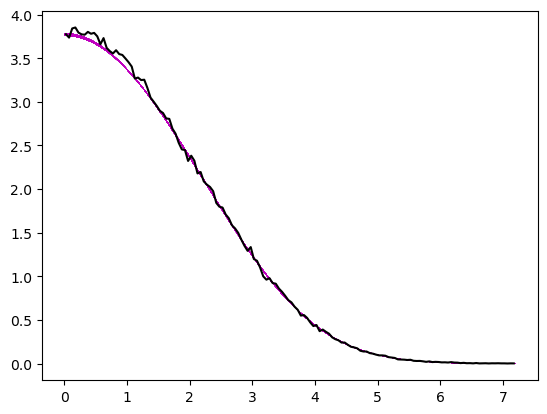

In [84]:
# now plot the new data 
for i in range(len(bcs)):    
    plt.scatter(zsparse_all,bcs[i],s=0.1,lw=0.1,c='m')
plt.plot(z,concentration_profiles[0],'k')
plt.show()

In [85]:
# compute the correlation coefficients
stdparam = np.std(bparams,axis=0)
mxy = np.outer(stdparam,stdparam) #<x><y>
covparam = np.cov(bparams.T,ddof=0) # <xy>
#print(covparam)
covcorr = covparam/mxy
print(covcorr)

[[ 1.         -0.91679556  0.85306505]
 [-0.91679556  1.         -0.98563356]
 [ 0.85306505 -0.98563356  1.        ]]


Note that parameters are highly correlated, as you can see by the correlation matrix  - there are multiple parameters that give essentially the same result. It may be a 2 parameter fit is enough!  Bootstrapping over osmotic coefficients should give less noisy results.

Parma 0 = 2.759411010916056 +/- 0.22044891312267728


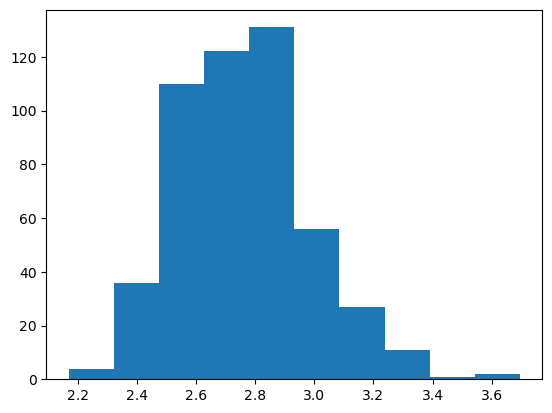

Parma 1 = 0.177086993711942 +/- 0.011027640322581127


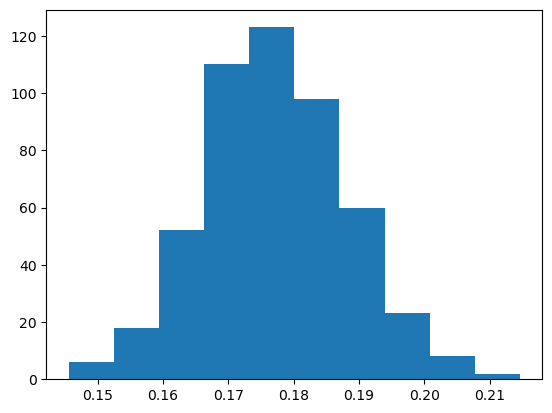

Parma 2 = -0.008446982695016363 +/- 0.001830999300098554


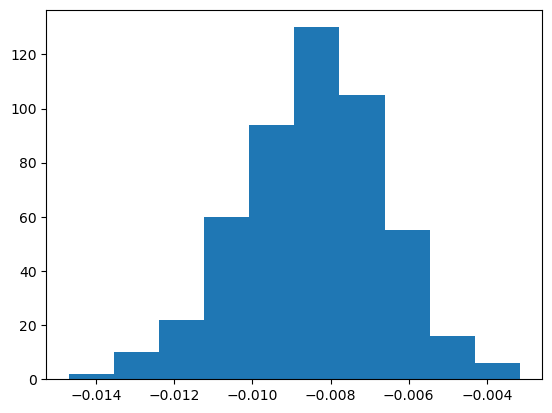

In [86]:
for i in range(len(bparams[0,:])):
    pd = bparams[:,i]
    std_param = np.std(pd) 
    mean_param = np.mean(pd)  # it's actually more accurate to
                             # just use the single fits, but we don't 
                             # necessarily know the name of that results structure
                             # when we are at this point in the code, use the mean for now
    print(f"Parma {i} = {mean_param} +/- {std_param}")
    plt.hist(pd)
    plt.show()

Note that the standard deviations of the parameters are lower with the maximum likelihood approximation.

B: 
weighted: 1.33 +/- 0.65
ML: 2.54 +/- 0.44

$\alpha_1$: 
weighted: 0.357 +/- 0.127
ML: 0.223 +/- 0.025

$\alpha_2$: 
weighted: -0.0317 +/- 0.0102
ML:  -0.0205 +/- 0.0041

Note that it is OK that the uncertainties are not within each other, since this is a highly correlated problem, so there are multiple solutions - small change in optimization can lead to large changes in the parameters while still being relatively close. 

In [87]:
def osmotic_pressure(cs,params, nu=2):
    # takes in a concentration, model parameters and nu. 
    term1 = cs
    term2 = params[1]*0.5*cs**2
    term3 = params[2]*(1/3.0)*cs**3
    csh = np.sqrt(cs)
    B = params[0]
    Bf = 1+B*csh
    term4 = (A/B**2)*((2/B)*np.log(Bf) - (2*csh+B*cs)/Bf)    
    p = nu*R*T*(term1+term2+term3+term4)
    ip = nu*R*T*cs  # this should be the ideal osmotic pressure
    return p,p/ip

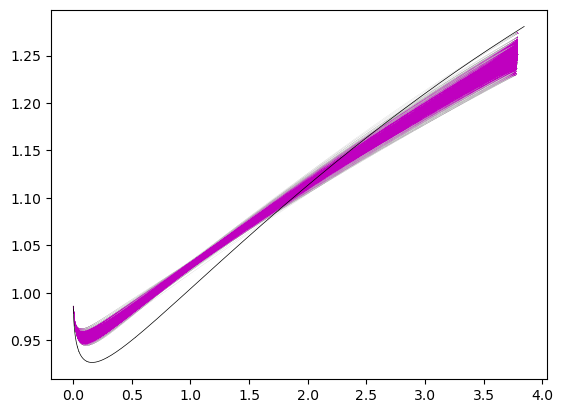

In [88]:
# scatter plots of the osmotic coefficients and osmotic pressures
ops = list()
ocs = list()
for p,c in zip(bparams,bcs):
    op,oc = osmotic_pressure(c,p)
    plt.scatter(c,oc,s=0.1,lw=0.1,alpha=0.01,c='m')
    ops.append(op)
    ocs.append(oc)
opt_oc = osmotic_pressure(c_opt_sparse_all,full_opt)[1]
plt.plot(c_opt_sparse_all,opt_oc,'k',lw=0.5,)
ops = np.array(ops)
ocs = np.array(ocs)
plt.show()

## Bootstrap over osmotic coefficients

In [113]:
from sklearn.metrics import r2_score, mean_squared_error
# Function to calculate R^2 and RMSE
def stats(true, pred):
    r2 = r2_score(true, pred)
    rmse = np.sqrt(mean_squared_error(true, pred))
    return r2, rmse

# Bootstrap function
def bootstrap_mols(xarr, yarr, n_bootstraps):
    r2_list = []
    rmse_list = []

    n_samples = len(xarr)
    for _ in range(n_bootstraps):
        # Sampling molecule indices with replacement
        sample_indices = np.random.choice(n_samples, n_samples, replace=True)
        sample_true = np.array(yarr)[sample_indices]
        sample_pred = np.array(xarr)[sample_indices]
        
        # Calculate R^2 and RMSE from the sample
        r2, rmse = stats(sample_true, sample_pred)
        r2_list.append(r2)
        rmse_list.append(rmse)
    
    # Calculating error bounds
    r2_bounds = (np.percentile(r2_list, 2.5), np.percentile(r2_list, 97.5))
    rmse_bounds = (np.percentile(rmse_list, 2.5), np.percentile(rmse_list, 97.5))

    return r2_bounds, rmse_bounds

In [126]:
r2,rmse=stats(oc,opt_oc)
r2_bounds, rmse_bounds = bootstrap_mols(oc, opt_oc, n_bootstraps=500)

print(f"R^2 bounds: {r2_bounds}")
print(f"RMSE bounds: {rmse_bounds}")

R^2 bounds: (0.9614651774181854, 0.9624299644088873)
RMSE bounds: (0.024873488488525088, 0.02524049790420557)


## Plot osmotic coefficient results

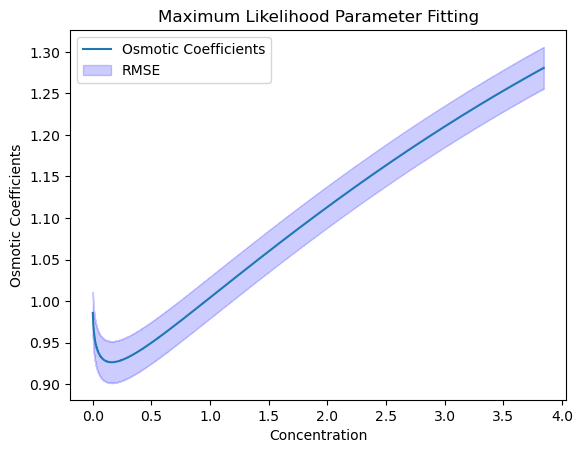

In [128]:
lower_bound = rmse_bounds[0]
upper_bound = rmse_bounds[1]
# Plotting the results
plt.plot(c_opt_sparse_all, opt_oc, label='Osmotic Coefficients')
plt.fill_between(c_opt_sparse_all, 
                 np.array(opt_oc) - lower_bound, 
                 np.array(opt_oc) + upper_bound,
                 color='b', alpha=0.2, label='RMSE')
plt.xlabel('Concentration')
plt.ylabel('Osmotic Coefficients')
plt.legend()
plt.title('Maximum Likelihood Parameter Fitting')
plt.show()

## Old plots

[1.23540244 1.23540241 1.23540241 ... 0.98545178 0.985516   0.98551838]


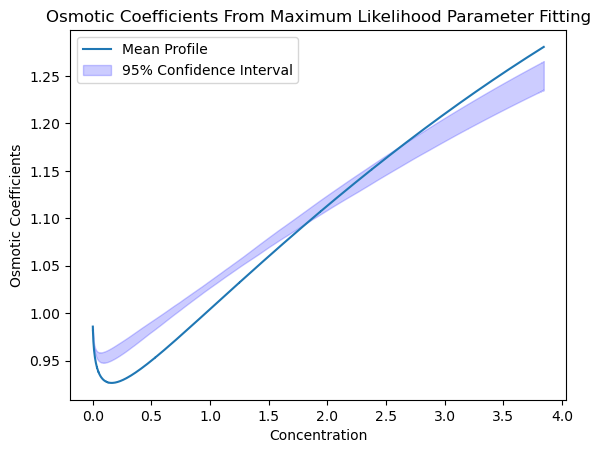

In [112]:
lower_bound = np.percentile(ocs, 2.5, axis=0)
print(lower_bound)
upper_bound = np.percentile(ocs, 97.5, axis=0)
# Plotting the results
plt.plot(c_opt_sparse_all, opt_oc, label='Mean Profile')
plt.fill_between(c_opt_sparse_all, lower_bound, upper_bound, color='b', alpha=0.2, label='95% Confidence Interval')
plt.xlabel('Concentration')
plt.ylabel('Osmotic Coefficients')
plt.legend()
plt.title('Osmotic Coefficients From Maximum Likelihood Parameter Fitting')
plt.show()


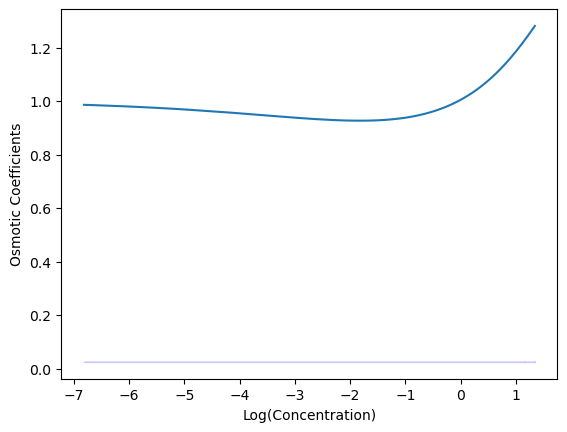

In [130]:

plt.plot(np.log(c_opt_sparse_all), opt_oc, label='Mean Profile')
plt.fill_between(np.log(c_opt_sparse_all), lower_bound, upper_bound, color='b', alpha=0.2, label='95% Confidence Interval')
plt.xlabel('Log(Concentration)')
plt.ylabel('Osmotic Coefficients')
plt.show()